# Prospective areas to set-up a Gym in New York

Install libraries

In [14]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [15]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



Import Libraries

In [16]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

import json # library to handle JSON files
from pandas.io.json import json_normalize

import folium # map rendering library

import requests

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.pyplot import subplots

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


# Download and Explore dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

This dataset exists for free on the web. The link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

### Load and Explore the data

In [17]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [18]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [19]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into pandas dataset

The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [20]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [21]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [22]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [23]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [24]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=18)
folium.Marker([latitude, longitude], popup='New York City').add_to(map_newyork)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Category id for metro stations: 4bf58dd8d48988d1fd931735

Source: https://developer.foursquare.com/docs/resources/categories

### Get the metro stations in New York City in radius of 15 km¶

In [25]:
CLIENT_ID = '2QRGY1TL4WUUKLOXPNZH12ETFMSI2RQF2DM0YDLAMNQ2XGYP' # your Foursquare ID
CLIENT_SECRET = 'QYJOEZSEIDDALJR2K0GEY3GQK4TXPVBOET3MFTKYSM1PCTAZ' # your Foursquare Secret
VERSION = '20200405' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

radius = 15000
LIMIT = 200
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

Your credentails:
CLIENT_ID: 2QRGY1TL4WUUKLOXPNZH12ETFMSI2RQF2DM0YDLAMNQ2XGYP
CLIENT_SECRET:QYJOEZSEIDDALJR2K0GEY3GQK4TXPVBOET3MFTKYSM1PCTAZ


In [26]:
url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius,
    LIMIT
)

In [27]:
stations_list = requests.get(url).json()['response']['groups'][0]['items']
stations_init_df = json_normalize(stations_list)

stations_init_df.head(2)

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.neighborhood,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.address,venue.location.crossStreet,venue.venuePage.id
0,e-0-5b9400f7b6b04b002c0c38f2-0,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",5b9400f7b6b04b002c0c38f2,MTA Subway - Cortlandt St WTC (1),40.711753,-74.011791,"[{'label': 'display', 'lat': 40.71175341389467, 'lng': -74.01179060853417}]",499,10007,US,Financial District,New York,NY,United States,"[New York, NY 10007, United States]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN,NaN
1,e-0-42829c80f964a5206a221fe3-1,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",42829c80f964a5206a221fe3,Grand Central Terminal,40.752809,-73.977014,NaN,5088,10017,US,NaN,New York,NY,United States,"[87 E 42nd St (btwn Vanderbilt & Park Ave), New York, NY 10017, United States]","[{'id': '4bf58dd8d48988d129951735', 'name': 'Train Station', 'pluralName': 'Train Stations', 'shortName': 'Train Station', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/trainstation_', 'suffix': '.png'}, 'primary': True}]",0,[],87 E 42nd St,btwn Vanderbilt & Park Ave,91385129


#### Extract station information

In [28]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
stations_filtered_df = stations_init_df.loc[:, filtered_columns]

# filter the category for each row
stations_filtered_df['venue_type'] = stations_init_df['venue.categories'].apply(lambda x: dict(x[0])['name'])

# clean columns
stations_filtered_df.columns = [col.split('.')[-1] for col in stations_filtered_df.columns]

stations_df = stations_filtered_df[stations_filtered_df['venue_type'] == 'Metro Station']
stations_df = stations_df.drop('categories', axis=1)
stations_df.head()

,name,lat,lng,distance,postalCode,venue_type
0,MTA Subway - Cortlandt St WTC (1),40.711753,-74.011791,499,10007,Metro Station
2,World Trade Center Transportation Hub (The Oculus),40.711599,-74.011465,476,10007,Metro Station
3,MTA Subway - Park Place (2/3),40.712727,-74.007763,147,NaN,Metro Station
4,MTA Subway - Brooklyn Bridge/City Hall/Chambers St (4/5/6/J/Z),40.712459,-74.005054,86,10007,Metro Station
5,MTA Subway - Chambers St (A/C/E),40.714086,-74.008584,264,10007,Metro Station


In [29]:
stations_df.shape

(98, 6)

#### Check that all the rows indeed represent a metro station

In [30]:
stations_df[stations_df['name'].str.find('Station') == -1]

,name,lat,lng,distance,postalCode,venue_type
0,MTA Subway - Cortlandt St WTC (1),40.711753,-74.011791,499,10007,Metro Station
2,World Trade Center Transportation Hub (The Oculus),40.711599,-74.011465,476,10007,Metro Station
3,MTA Subway - Park Place (2/3),40.712727,-74.007763,147,NaN,Metro Station
4,MTA Subway - Brooklyn Bridge/City Hall/Chambers St (4/5/6/J/Z),40.712459,-74.005054,86,10007,Metro Station
5,MTA Subway - Chambers St (A/C/E),40.714086,-74.008584,264,10007,Metro Station
6,MTA Subway - World Trade Center (E),40.712407,-74.009973,335,10007,Metro Station
7,MTA Subway - Fulton St (A/C/J/Z/2/3/4/5),40.710706,-74.009243,353,10038,Metro Station
8,MTA Subway - Chambers St (1/2/3),40.715531,-74.009288,416,NaN,Metro Station
9,MTA Subway - Cortlandt St (R/W),40.711806,-74.011610,483,NaN,Metro Station
11,MTA Subway - Wall St (2/3),40.706513,-74.009463,750,10005,Metro Station


In [31]:
#Indeed the above rows are 'parking' places for trains. They need to be removed from the dataframe
# Keep only the stations that their name contains 'Station' 

stations_df = stations_df[stations_df['name'].str.contains('Station')]
stations_df.shape

(11, 6)

In [32]:
stations_df.head()

,name,lat,lng,distance,postalCode,venue_type
10,World Trade Center PATH Station,40.711807,-74.011687,489,10006,Metro Station
33,Exchange Place PATH Station,40.716249,-74.033207,2327,07302,Metro Station
34,9th Street PATH Station,40.734119,-73.998916,2455,10011,Metro Station
39,Newport PATH Station,40.726838,-74.034201,2849,07310,Metro Station
40,14th Street PATH Station,40.737438,-73.996931,2855,10011,Metro Station


In [33]:
stations_df.rename(columns={'name': 'station',
                            'distance': 'Distance from Center',
                            'postalCode': 'Postal Code',
                            'venue_type': 'Venue Type'},
                   inplace=True)

stations_df.reset_index(drop=True, inplace=True)

print(stations_df.info())
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
station                 11 non-null object
lat                     11 non-null float64
lng                     11 non-null float64
Distance from Center    11 non-null int64
Postal Code             11 non-null object
Venue Type              11 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 656.0+ bytes
None


,station,lat,lng,Distance from Center,Postal Code,Venue Type
0,World Trade Center PATH Station,40.711807,-74.011687,489,10006,Metro Station
1,Exchange Place PATH Station,40.716249,-74.033207,2327,07302,Metro Station
2,9th Street PATH Station,40.734119,-73.998916,2455,10011,Metro Station
3,Newport PATH Station,40.726838,-74.034201,2849,07310,Metro Station
4,14th Street PATH Station,40.737438,-73.996931,2855,10011,Metro Station


#### Visualize the metro stations on a map of New York

In [34]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, station in zip(stations_df['lat'],
                          stations_df['lng'],
                          stations_df['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_newyork)
    
map_newyork

## Get the gyms near the stations

Category id for Gym / Fitness Center: 4bf58dd8d48988d175941735

Source: https://developer.foursquare.com/docs/resources/categories

Function to create a dataframe with the results gathered from Foursquare API on a specific category

In [35]:
def getNearbyGyms(categoryId, stations, latitudes, longitudes, radius=750):
    
    print('Finding gyms near New York metro stations, please wait...\n')
    
    gyms_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby gym
        gyms_list.append([(
            station,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])
    nearby_gyms_df = pd.DataFrame([item for venue_list in gyms_list for item in venue_list])
    nearby_gyms_df.columns = [
                  'station',
                  'lat',
                  'lng',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Station',
                  'Venue Category']
    print('Finished')
    return(nearby_gyms_df)

#### Use the function to gather information about existing gyms in a radius of 750m around each metro station in New York

In [36]:
categoryId = '4bf58dd8d48988d175941735' # Gym / Fitness Center
gyms_venues_df = getNearbyGyms(categoryId, stations=stations_df['station'], latitudes=stations_df['lat'], longitudes=stations_df['lng'])

Finding gyms near New York metro stations, please wait...

Finished


In [37]:
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,World Trade Center PATH Station,40.711807,-74.011687,The Class by Taryn Toomey,40.712753,-74.008734,270,Gym / Fitness Center
1,World Trade Center PATH Station,40.711807,-74.011687,Equinox Brookfield Place,40.712704,-74.014995,296,Gym / Fitness Center
2,World Trade Center PATH Station,40.711807,-74.011687,Crunch - FiDi,40.708614,-74.010013,382,Gym / Fitness Center
3,World Trade Center PATH Station,40.711807,-74.011687,Equinox Tribeca,40.714099,-74.009686,305,Gym / Fitness Center
4,World Trade Center PATH Station,40.711807,-74.011687,Exceed Physical Culture,40.715629,-74.007992,527,Gym / Fitness Center


#### Let's check the categories of venues that were returned for each neighborhood

In [38]:
gyms_venues_df.groupby(['Venue Category']).count()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Advertising Agency,1,1,1,1,1,1,1
Athletics & Sports,2,2,2,2,2,2,2
Boxing Gym,10,10,10,10,10,10,10
Construction & Landscaping,2,2,2,2,2,2,2
Cycle Studio,5,5,5,5,5,5,5
Dance Studio,3,3,3,3,3,3,3
Gym,186,186,186,186,186,186,186
Gym / Fitness Center,435,435,435,435,435,435,435
Gym Pool,2,2,2,2,2,2,2


#### We will only keep the two categories [Gym, Gym / Fitness Center]

In [39]:
gyms_venues_df = gyms_venues_df[gyms_venues_df['Venue Category'].isin(['Gym', 'Gym / Fitness Center'])]
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,World Trade Center PATH Station,40.711807,-74.011687,The Class by Taryn Toomey,40.712753,-74.008734,270,Gym / Fitness Center
1,World Trade Center PATH Station,40.711807,-74.011687,Equinox Brookfield Place,40.712704,-74.014995,296,Gym / Fitness Center
2,World Trade Center PATH Station,40.711807,-74.011687,Crunch - FiDi,40.708614,-74.010013,382,Gym / Fitness Center
3,World Trade Center PATH Station,40.711807,-74.011687,Equinox Tribeca,40.714099,-74.009686,305,Gym / Fitness Center
4,World Trade Center PATH Station,40.711807,-74.011687,Exceed Physical Culture,40.715629,-74.007992,527,Gym / Fitness Center


#### Make sure unwanted venues were removed

In [40]:
gyms_venues_df.groupby(['Venue Category']).count().head(10)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Gym,186,186,186,186,186,186,186
Gym / Fitness Center,435,435,435,435,435,435,435


#### Add distance from each metro station to the nearest gym and number of existing gyms in its vicinity

Add to the data frame the minimum distance of every station to the gyms in its vicinity

In [41]:
gyms_venues_min_df = pd.merge(gyms_venues_df,
                              pd.DataFrame(gyms_venues_df.groupby('station')['Distance from Station'].min()),
                              on='station', how='inner')

In [42]:
gyms_venues_min_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y
0,World Trade Center PATH Station,40.711807,-74.011687,The Class by Taryn Toomey,40.712753,-74.008734,270,Gym / Fitness Center,47
1,World Trade Center PATH Station,40.711807,-74.011687,Equinox Brookfield Place,40.712704,-74.014995,296,Gym / Fitness Center,47
2,World Trade Center PATH Station,40.711807,-74.011687,Crunch - FiDi,40.708614,-74.010013,382,Gym / Fitness Center,47
3,World Trade Center PATH Station,40.711807,-74.011687,Equinox Tribeca,40.714099,-74.009686,305,Gym / Fitness Center,47
4,World Trade Center PATH Station,40.711807,-74.011687,Exceed Physical Culture,40.715629,-74.007992,527,Gym / Fitness Center,47


#### Add the number of already existing gyms in the vicinity of each station

In [43]:
gyms_venues_min_count_df = pd.merge(gyms_venues_min_df,
                           pd.DataFrame(gyms_venues_min_df.groupby(['station']).count())['lat'],
                           on='station', how='inner')

In [44]:
gyms_venues_min_count_df.head()

,station,lat_x,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y,lat_y
0,World Trade Center PATH Station,40.711807,-74.011687,The Class by Taryn Toomey,40.712753,-74.008734,270,Gym / Fitness Center,47,94
1,World Trade Center PATH Station,40.711807,-74.011687,Equinox Brookfield Place,40.712704,-74.014995,296,Gym / Fitness Center,47,94
2,World Trade Center PATH Station,40.711807,-74.011687,Crunch - FiDi,40.708614,-74.010013,382,Gym / Fitness Center,47,94
3,World Trade Center PATH Station,40.711807,-74.011687,Equinox Tribeca,40.714099,-74.009686,305,Gym / Fitness Center,47,94
4,World Trade Center PATH Station,40.711807,-74.011687,Exceed Physical Culture,40.715629,-74.007992,527,Gym / Fitness Center,47,94


#### Giving appropriate names to the dataframe columns

In [45]:
gyms_df = gyms_venues_min_count_df.rename(columns={'lat_x': 'lat', 'Distance from Station_x': 'Distance from Station',
                                                   'Distance from Station_y': 'Min Distance from Station',
                                                   'lat_y': 'Gym Count'})
gyms_df.head(15)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category,Min Distance from Station,Gym Count
0,World Trade Center PATH Station,40.711807,-74.011687,The Class by Taryn Toomey,40.712753,-74.008734,270,Gym / Fitness Center,47,94
1,World Trade Center PATH Station,40.711807,-74.011687,Equinox Brookfield Place,40.712704,-74.014995,296,Gym / Fitness Center,47,94
2,World Trade Center PATH Station,40.711807,-74.011687,Crunch - FiDi,40.708614,-74.010013,382,Gym / Fitness Center,47,94
3,World Trade Center PATH Station,40.711807,-74.011687,Equinox Tribeca,40.714099,-74.009686,305,Gym / Fitness Center,47,94
4,World Trade Center PATH Station,40.711807,-74.011687,Exceed Physical Culture,40.715629,-74.007992,527,Gym / Fitness Center,47,94
5,World Trade Center PATH Station,40.711807,-74.011687,Physique 57,40.706844,-74.013014,563,Gym / Fitness Center,47,94
6,World Trade Center PATH Station,40.711807,-74.011687,Equinox Wall Street,40.707273,-74.010543,513,Gym,47,94
7,World Trade Center PATH Station,40.711807,-74.011687,Xtend Barre Tribeca,40.715227,-74.010385,396,Gym / Fitness Center,47,94
8,World Trade Center PATH Station,40.711807,-74.011687,American Express Fitness Center,40.713752,-74.014276,307,Gym / Fitness Center,47,94
9,World Trade Center PATH Station,40.711807,-74.011687,Just Train,40.709470,-74.009840,303,Gym,47,94


#### Retaining only the necessary columns

In [46]:
gyms_df = gyms_df[['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count']].drop_duplicates()

In [47]:
gyms_df.head(10)

,station,lat,lng,Min Distance from Station,Gym Count
0,World Trade Center PATH Station,40.711807,-74.011687,47,94
94,Exchange Place PATH Station,40.716249,-74.033207,155,26
120,9th Street PATH Station,40.734119,-73.998916,66,72
192,Newport PATH Station,40.726838,-74.034201,48,24
216,14th Street PATH Station,40.737438,-73.996931,42,81
297,Grove Street PATH Station,40.719785,-74.042707,67,45
342,Hoboken PATH Station,40.735691,-74.029110,79,23
365,33rd St PATH Station,40.748613,-73.988417,60,81
446,MTA Subway - 34th St/Penn Station (1/2/3),40.750996,-73.990688,98,84
530,MTA Subway - 34th St/Penn Station (A/C/E),40.751995,-73.992888,99,87


#### Checking how many metro stations are there with existing gym

In [48]:
gyms_df.shape

(11, 5)

#### We will now merge the initial stations_df dataframe with the previously created gyms_df and assign 10000 to 'Min Distance from Station' and 0 to 'Gym Count'

In [49]:
missing_stations_df = pd.merge(stations_df[['station', 'lat', 'lng']], gyms_df,
                                    on='station', how='left')
missing_stations_df[missing_stations_df['Gym Count'].isnull()]

,station,lat_x,lng_x,lat_y,lng_y,Min Distance from Station,Gym Count


In [50]:
#### This shows that no stations are having 0 gyms around it.

In [51]:
stations_gyms_grouped_df = gyms_df.copy()

In [52]:
stations_gyms_grouped_df.shape

(11, 5)

In [53]:
stations_gyms_grouped_df.head()

,station,lat,lng,Min Distance from Station,Gym Count
0,World Trade Center PATH Station,40.711807,-74.011687,47,94
94,Exchange Place PATH Station,40.716249,-74.033207,155,26
120,9th Street PATH Station,40.734119,-73.998916,66,72
192,Newport PATH Station,40.726838,-74.034201,48,24
216,14th Street PATH Station,40.737438,-73.996931,42,81


#### Normalize Data [Min Distance from Station, Gym Count]

Data Standardization give data zero mean and unit variance

In [54]:
print('All stations mean distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].mean())
print('All stations maximum distance from any gym: ',stations_gyms_grouped_df['Min Distance from Station'].max())
print('All stations minimum distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].min())
print('All stations mean of number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].mean())
print('All stations maximum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].max())
print('All stations minimum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].min())

All stations mean distance from any gym:  91.45454545454545
All stations maximum distance from any gym:  245
All stations minimum distance from any gym:  42
All stations mean of number of existing gyms:  56.45454545454545
All stations maximum number of existing gyms:  94
All stations minimum number of existing gyms:  4


In [55]:
stations_gyms_grouped_df['Norm Min Distance from Station'] = (stations_gyms_grouped_df['Min Distance from Station'] - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].mean()) / \
                                                             (stations_gyms_grouped_df['Min Distance from Station'].max() - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].min())
stations_gyms_grouped_df['Norm Gym Count'] = (stations_gyms_grouped_df['Gym Count'] - stations_gyms_grouped_df['Gym Count'].mean()) / \
                                             (stations_gyms_grouped_df['Gym Count'].max() - stations_gyms_grouped_df['Gym Count'].min())


In [56]:
stations_gyms_grouped_df['Gym Count'] = stations_gyms_grouped_df['Gym Count'].astype(int)

In [57]:
stations_gyms_grouped_df.reset_index(drop=True, inplace=True)

In [58]:
stations_gyms_grouped_df.head(10)

,station,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,World Trade Center PATH Station,40.711807,-74.011687,47,94,-0.218988,0.417172
1,Exchange Place PATH Station,40.716249,-74.033207,155,26,0.313032,-0.338384
2,9th Street PATH Station,40.734119,-73.998916,66,72,-0.125392,0.172727
3,Newport PATH Station,40.726838,-74.034201,48,24,-0.214062,-0.360606
4,14th Street PATH Station,40.737438,-73.996931,42,81,-0.243618,0.272727
5,Grove Street PATH Station,40.719785,-74.042707,67,45,-0.120466,-0.127273
6,Hoboken PATH Station,40.735691,-74.029110,79,23,-0.061352,-0.371717
7,33rd St PATH Station,40.748613,-73.988417,60,81,-0.154948,0.272727
8,MTA Subway - 34th St/Penn Station (1/2/3),40.750996,-73.990688,98,84,0.032244,0.306061
9,MTA Subway - 34th St/Penn Station (A/C/E),40.751995,-73.992888,99,87,0.037170,0.339394


### K- Means Clustering

#### Prepare the dataframe to be used in K-Means algorithm

In [59]:
gyms_clustering_df = stations_gyms_grouped_df.drop(['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count'], 1)

In [60]:
gyms_clustering_df.head()

,Norm Min Distance from Station,Norm Gym Count
0,-0.218988,0.417172
1,0.313032,-0.338384
2,-0.125392,0.172727
3,-0.214062,-0.360606
4,-0.243618,0.272727


#### Cluster Locations (Metro stations) in New York (K-Means Clustering)

The KMeans class has many parameters that can be used, but we will be using these three:

init: Initialization method of the centroids.

Value will be: "k-means++"

k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.

n_clusters: The number of clusters to form as well as the number of centroids to generate.

Value will be: 4 (since we have 4 centers)

n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

Value will be: 12

#### Use the Elbow method to find the best k for clustering

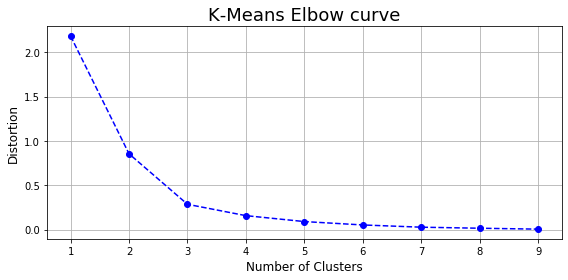

In [61]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(1, 10):
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init = 12, max_iter=300, tol=0.00001)
    kmeans.fit(gyms_clustering_df)
    distorsions.append(kmeans.inertia_)

fig, ax = subplots(figsize=(8, 4))
ax.plot(range(1, 10), distorsions, '--bo')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Distortion', fontsize=12)
plt.grid(True)
plt.title('K-Means Elbow curve', fontsize='18')
plt.tight_layout()
plt.show()

The elbow graph, although not very steep, presents an elbow point at 3 number of clusters.

#### Run k-means to cluster the station areas to 3 clusters

In [62]:
# venues_grouped_clustering_df = venues_grouped_df.drop('station', 1)
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=0, n_init = 12, max_iter=300, tol=0.0001)
kmeans.fit(gyms_clustering_df)

kmeans.labels_

array([0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 1])

### K-Means Clustering Results

#### Create a new dataframe that includes the resulted clusters and relevant metro station information

In [63]:
# add clustering labels
stations_gyms_grouped_df.insert(1, 'Cluster Label', kmeans.labels_)

In [64]:
stations_gyms_grouped_df.head()

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,World Trade Center PATH Station,0,40.711807,-74.011687,47,94,-0.218988,0.417172
1,Exchange Place PATH Station,1,40.716249,-74.033207,155,26,0.313032,-0.338384
2,9th Street PATH Station,0,40.734119,-73.998916,66,72,-0.125392,0.172727
3,Newport PATH Station,2,40.726838,-74.034201,48,24,-0.214062,-0.360606
4,14th Street PATH Station,0,40.737438,-73.996931,42,81,-0.243618,0.272727


#### Visualize the metro stations clusters on a map of New York

In [65]:
cluster_colors = ['green', 'red', 'blue'] 

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

markers_colors = []
for lat, lon, poi, cluster in zip(stations_gyms_grouped_df['lat'], stations_gyms_grouped_df['lng'], 
                                  stations_gyms_grouped_df['station'], stations_gyms_grouped_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Now visualize the (normalized) clusters distribution on a scatter plot along with their final corresponding centroids

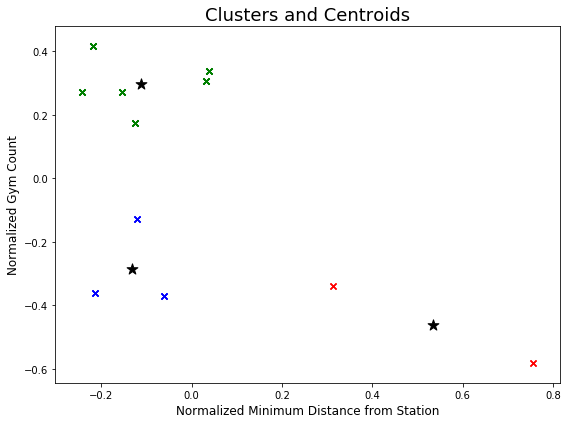

In [66]:
fig, ax = subplots(figsize=(8, 6))
for label in kmeans.labels_:
    plt.scatter(stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Min Distance from Station'],
                stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Gym Count'],
                marker='x', color=cluster_colors[label])
    
for centroid in kmeans.cluster_centers_:
    plt.scatter(centroid[0], centroid[1], s=130, marker="*", color='black')
    
ax.set_xlabel('Normalized Minimum Distance from Station', fontsize=12)
ax.set_ylabel('Normalized Gym Count', fontsize=12)
plt.title('Clusters and Centroids', fontsize='18')
plt.tight_layout()
plt.show()

#### Show the Metro stations that correspond to each cluster

#### Cluster 1 (LOW potential)

There are already many existing gyms in the area and the nearest gym is in most cases in a relatively short distance from the station

In [67]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 0]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,World Trade Center PATH Station,0,40.711807,-74.011687,47,94,-0.218988,0.417172
2,9th Street PATH Station,0,40.734119,-73.998916,66,72,-0.125392,0.172727
4,14th Street PATH Station,0,40.737438,-73.996931,42,81,-0.243618,0.272727
7,33rd St PATH Station,0,40.748613,-73.988417,60,81,-0.154948,0.272727
8,MTA Subway - 34th St/Penn Station (1/2/3),0,40.750996,-73.990688,98,84,0.032244,0.306061
9,MTA Subway - 34th St/Penn Station (A/C/E),0,40.751995,-73.992888,99,87,0.037170,0.339394


#### Cluster 2 (HIGH potential)

There are not many already existing gyms in the area and the nearest gym is in most cases relatively not in a short distance to the metro station

In [68]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 1]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
1,Exchange Place PATH Station,1,40.716249,-74.033207,155,26,0.313032,-0.338384
10,Journal Square PATH Station,1,40.732037,-74.062827,245,4,0.756382,-0.582828


#### Cluster 3 (AVERAGE potential)

Although not a prohibitive metro station to open a gym in its vicinity, there is already a fair number of gyms in the area and the nearest one is not far from the metro station

In [69]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 2]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
3,Newport PATH Station,2,40.726838,-74.034201,48,24,-0.214062,-0.360606
5,Grove Street PATH Station,2,40.719785,-74.042707,67,45,-0.120466,-0.127273
6,Hoboken PATH Station,2,40.735691,-74.029110,79,23,-0.061352,-0.371717


### Discussion

Clusters of areas (in our case Metro stations) were identified as groups of similar in their potential locations for opening a gym.

Possible areas that were not in the Foursquare database should also be examined so that it can be determined if it is just lack of data about these stations or indeed there are no gyms in the vicinity of the stations. A lot more factors can be considered when choosing an appropriate location. Some examples of extra factors can be:

1) Population density in the area

2) Number of businesses operating in the area (people may want to go to a gym close to work)

3) Average age and household income in the area

4) Property prices in the area

### Conclusion

The above results can be a good starting point for a prospective businessman that is interested in opening a gym. Similar methodology can be used for other types of businesses probably with customized criteria.

With the availability of a number of different tools and Machine Learning algorithms, it is possible to find solutions (or possible solutions) to an ever increasing number of problems and queries.

And it is getting better and better!